## Titanic Dataset For Kaggle Competition

In [1]:
import os
import sklearn
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Run The Below Two Cells To Download The Titanic Dataset From Kaggle (Requires API Key)

In [3]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# api = KaggleApi()
# api.authenticate()

# api.competition_download_files("titanic", path=".", quiet=False)

# # Unzip it
# with zipfile.ZipFile("titanic.zip", "r") as zip_ref:
#     zip_ref.extractall("titanic_data")

# # Remove the zip file
# os.remove("titanic.zip")

In [5]:
train_df = pd.read_csv("titanic_data/train.csv")
test_df = pd.read_csv("titanic_data/test.csv")

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
train_df['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

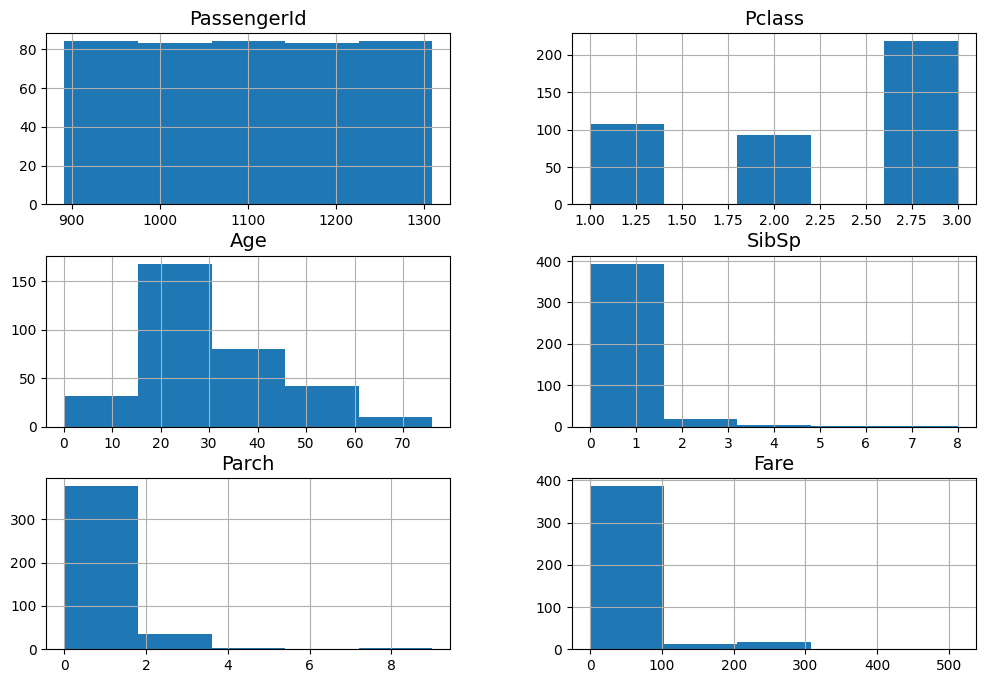

In [13]:
test_df.hist(bins=5, figsize=(12, 8))
plt.show()

In [14]:
corr_matrix = train_df.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [15]:
# --- Define Custom Transformer for Cleaning & Feature Engineering ---

class TitanicPreprocessor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        df = X.copy()

        # 1) Fare: overall median
        self.fare_imputer_ = df['Fare'].median()

        # 2) Embarked: most frequent port
        self.embarked_imputer_ = df['Embarked'].mode()[0]

        # 3) CabinDeck: first letter of cabin, mode for imputation
        decks = df['Cabin'].dropna().apply(lambda cab: cab[0])
        self.cabin_deck_imputer_ = decks.mode()[0]

        # 4) Title: extract and compute median Age per Title
        titles = df['Name'].apply(self._extract_title)
        age_by_title = pd.DataFrame({'Title': titles, 'Age': df['Age']})
        self.age_median_by_title_ = (
            age_by_title.groupby('Title')['Age']
            .median()
            .to_dict()
        )
        # Fallback overall median if title unseen
        self.age_overall_median_ = df['Age'].median()

        return self

    def transform(self, X):
        df = X.copy()

        # Impute Fare
        df['Fare'] = df['Fare'].fillna(self.fare_imputer_)

        # Impute Embarked
        df['Embarked'] = df['Embarked'].fillna(self.embarked_imputer_)

        # CabinDeck extraction & imputation
        df['CabinDeck'] = (
            df['Cabin']
            .fillna('U')             # mark missing as Unknown
            .apply(lambda cab: cab[0] if cab != 'U' else 'U')
        )
        df.drop(columns=['Cabin'], inplace=True)

        # Title extraction
        df['Title'] = df['Name'].apply(self._extract_title)

        # Impute Age by title, fallback to overall median
        def impute_age(row):
            title = row['Title']
            if pd.isna(row['Age']):
                return self.age_median_by_title_.get(title, self.age_overall_median_)
            return row['Age']

        df['Age'] = df.apply(impute_age, axis=1)

        # Ticket prefix & number
        def split_ticket(ticket):
            parts = ticket.replace('.', '').replace('/', '').split()
            if len(parts) > 1:
                prefix = " ".join(parts[:-1])
                number = parts[-1]
            else:
                prefix = 'NONE'
                number = parts[0]
            return prefix, number

        ticket_split = df['Ticket'].apply(split_ticket)
        df['TicketPrefix'] = ticket_split.apply(lambda x: x[0])
        df['TicketNumber'] = ticket_split.apply(lambda x: x[1])
        df['TicketNumber'] = pd.to_numeric(df['TicketNumber'], errors='coerce')

        # FamilySize
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

        # Pclass -> categorical
        df['Pclass'] = df['Pclass'].astype('category')

        # Drop columns we’ve engineered out of
        df.drop(columns=['Name', 'Ticket'], inplace=True)

        return df

    @staticmethod
    def _extract_title(name: str) -> str:
        if ',' in name and '.' in name:
            return name.split(',')[1].split('.')[0].strip()
        return 'Unknown'

In [16]:
numeric_features = ['Age', 'Fare', 'FamilySize', 'TicketNumber']
categorical_features = [
    'Pclass',
    'Embarked',
    'CabinDeck',
    'Title',
    'TicketPrefix'
]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

In [17]:
titanic_pipeline = Pipeline([
    ('prep', TitanicPreprocessor()),
    ('feat', feature_processor)
])

X_train_raw = train_df.drop(columns=['Survived'])
y_train = train_df['Survived']
X_test_raw = test_df.copy()

X_train_processed = titanic_pipeline.fit_transform(X_train_raw, y_train)
X_test_processed = titanic_pipeline.transform(X_test_raw)

In [18]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

print(X_train_processed.shape, y_train.shape)

(891, 67) (891,)


In [19]:
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

In [20]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=X_train_split.shape[1:]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,301 (786.33 KB)

 Trainable params: 201,301 (786.33 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [23]:
history = model.fit(X_train_split, y_train_split, epochs=1,
                    validation_data=(X_val_split, y_val_split),
                    callbacks=[expon_lr])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6714 - loss: 0.5988 - val_accuracy: 0.8045 - val_loss: 0.4327


Text(0, 0.5, 'Loss')

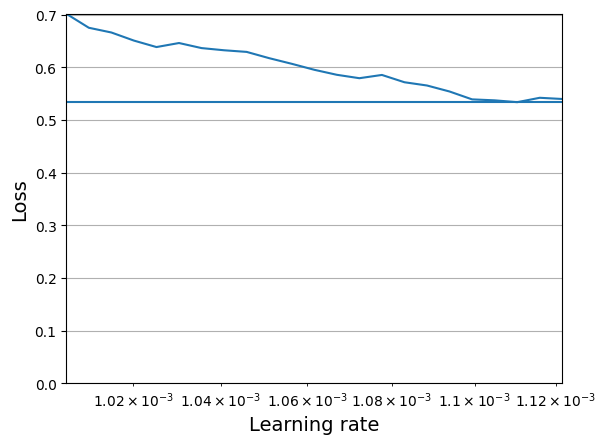

In [24]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [25]:
num_train_samples = X_train_split.shape[0]
batch_size = 32
epochs = 100

steps_per_epoch = tf.math.ceil(num_train_samples / batch_size).numpy()
print(f"Steps per epoch: {steps_per_epoch}")

total_training_steps = steps_per_epoch * epochs
print(f"Total training steps: {total_training_steps}")

Steps per epoch: 23.0
Total training steps: 2300.0


In [26]:
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.07e-3,
    decay_steps=230,
    decay_rate=0.96,
    staircase=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lrSchedule)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer,
              metrics=["accuracy"])

In [27]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit(X_train_processed, y_train, epochs=epochs,
                    callbacks=[early_stopping_cb])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8205 - loss: 0.4243   
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.3983
Epoch 3/100
20/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8672 - loss: 0.3587 

/Users/kourosh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.3585
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.3462
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8632 - loss: 0.3304
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.3150
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8762 - loss: 0.3031 
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.2868 
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.2886 
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.2847
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8871 - loss: 0.2602
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8848 - loss: 0.2630
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.2545
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8925

In [28]:
raw_predictions = model.predict(X_test_processed)
final_predictions = (raw_predictions > 0.5).astype(int)

if final_predictions.ndim > 1:
    final_predictions = final_predictions.flatten()

print("Creating submission file...")
submissionDf = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": final_predictions
})

submissionDf.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Creating submission file...
Submission file created successfully!
